In [1]:
import torch
import torch.nn as nn
import pandas as pd
import lzma
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
dataset = 'detailed'
n_layer = 1
n_feature = 2
fold = 1

In [3]:
# Load data
file_path = f'../sequence_data/{dataset}/profiles.csv.xz'
with lzma.open(file_path, 'rt') as file:
    signal_df = pd.read_csv(file)

seqs = tuple(signal_df.groupby('sequenceID'))

# Load target, features, and fold data
target_df = pd.read_csv(f'../training_data/{dataset}/target.csv')
features_df = pd.read_csv(f'../training_data/{dataset}/features.csv')[['sequenceID', 'loglog_count', 'log_variance']]
fold_df = pd.read_csv(f'../training_data/{dataset}/folds.csv')

# Get the sequence IDs where fold == 1
valid_sequence_ids = fold_df[fold_df['fold'] == fold]['sequenceID'].values

# Filter signal sequences based on valid sequence IDs
valid_seqs = [seq for seq in seqs if seq[0] in valid_sequence_ids]
raw_seqs = [torch.tensor(seq[1]['signal'].to_numpy(), dtype=torch.float32) for seq in valid_seqs]

# Filter target_df and features_df based on valid sequence IDs
target_df = target_df[target_df['sequenceID'].isin(valid_sequence_ids)]
features_df = features_df[features_df['sequenceID'].isin(valid_sequence_ids)]

In [4]:
class GRUModel(nn.Module):
    def __init__(self, input_size, n_feature, n_layer):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, n_feature, n_layer, batch_first=True)    # GRU
        self.fc = nn.Linear(n_feature, 1)                                         # Linear

    def forward(self, x):               
        gru_out, _ = self.gru(x)                            # Pass sequence through GRU    
        last_out = gru_out[:, -1, :]                        # Take the hidden state of the last time step 
        x = self.fc(last_out)                               # Linear combination         
        x = torch.relu(x + 10) - torch.relu(x - 10) - 10    # clamp between -10 and 10
        return x

In [5]:
model = GRUModel(1, n_feature, n_layer)  # Initialize the model structure
model.load_state_dict(torch.load(f"../model/RNN/saved_models/gru_{dataset}_{n_layer}layers_{n_feature}features_fold{fold}.pth", map_location=torch.device('cpu'), weights_only=True))
model.eval()

GRUModel(
  (gru): GRU(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [6]:
# Assuming raw_seqs, target_df, features_df, and model are defined
n_instances = 300

# Initialize lists to store values for plotting
lengths = []
variances = []
feature_1_vals = []
feature_2_vals = []
low_targets = []
up_targets = []

# Loop through raw sequences to compute GRU outputs and targets
for i in [random.randint(0, len(raw_seqs) - 1) for _ in range(n_instances)]:
    input_tensor = raw_seqs[i].unsqueeze(0).unsqueeze(-1)  # Prepare input tensor
    gru_output, _ = model.gru(input_tensor)  # Get GRU output
    feature_1, feature_2 = gru_output[:, -1, :][0].detach().numpy()  # Extract features
    length, variance = features_df.iloc[i][['loglog_count', 'log_variance']]
    low_target, up_target = target_df.iloc[i][['min.log.lambda', 'max.log.lambda']]  # Get targets

    # Append values for plotting
    lengths.append(length)
    variances.append(variance)
    feature_1_vals.append(feature_1)
    feature_2_vals.append(feature_2)
    low_targets.append(low_target)
    up_targets.append(up_target)

# Convert lists to NumPy arrays for easier manipulation
lengths = np.array(lengths)
variances = np.array(variances)
feature_1_vals = np.array(feature_1_vals)
feature_2_vals = np.array(feature_2_vals)
low_targets = np.array(low_targets)
up_targets = np.array(up_targets)

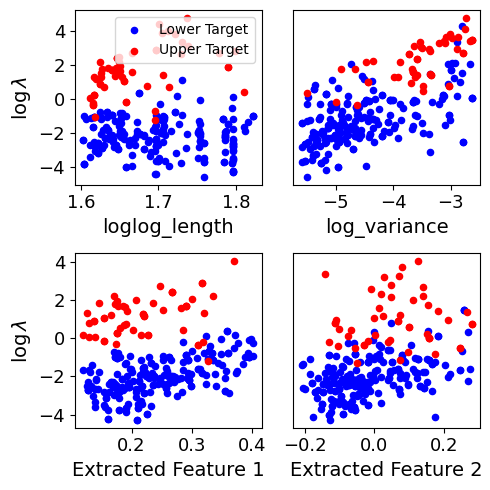

In [36]:
# hyperparas
size = 20

# Compute interquartile ranges
range = [10, 90]
q25_f1, q75_f1 = np.percentile(lengths, range)
q25_f2, q75_f2 = np.percentile(variances, range)
q25_f3, q75_f3 = np.percentile(feature_1_vals, range)
q25_f4, q75_f4 = np.percentile(feature_2_vals, range)

# Filter data within the interquartile range
filter_mask_f1 = (lengths >= q25_f1) & (lengths <= q75_f1)
filter_mask_f2 = (variances >= q25_f2) & (variances <= q75_f2)
filter_mask_f3 = (feature_1_vals >= q25_f3) & (feature_1_vals <= q75_f3)
filter_mask_f4 = (feature_2_vals >= q25_f4) & (feature_2_vals <= q75_f4)

# Create the plots
plt.figure(figsize=(5, 5))

# Plot 1: length vs Targets (filtered by interquartile range)
plt.subplot(2, 2, 1)
plt.scatter(lengths[filter_mask_f1], low_targets[filter_mask_f1], s=size,
            color='blue', label='Lower Target')
plt.scatter(lengths[filter_mask_f1], up_targets[filter_mask_f1], s=size,
            color='red', label='Upper Target')
plt.xlabel('loglog_length', fontsize=14)
plt.ylabel(r'$\log\lambda$', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

# Plot 2: variance vs Targets (filtered by interquartile range)
plt.subplot(2, 2, 2)
plt.scatter(variances[filter_mask_f2], low_targets[filter_mask_f2], s=size,
            color='blue', label='Lower Target')
plt.scatter(variances[filter_mask_f2], up_targets[filter_mask_f2], s=size,
            color='red', label='Upper Target')
plt.xlabel('log_variance', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks([])

# Plot 3: feature 1 vs Targets (filtered by interquartile range)
plt.subplot(2, 2, 3)
plt.scatter(feature_1_vals[filter_mask_f3], low_targets[filter_mask_f3], s=size,
            color='blue', label='Lower Target')
plt.scatter(feature_1_vals[filter_mask_f3], up_targets[filter_mask_f3], s=size,
            color='red', label='Upper Target')
plt.xlabel('Extracted Feature 1', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel(r'$\log\lambda$', fontsize=14)
plt.yticks(fontsize=13)

# Plot 4: Feature_2 vs Targets (filtered by interquartile range)
plt.subplot(2, 2, 4)
plt.scatter(feature_2_vals[filter_mask_f4], low_targets[filter_mask_f4], s=size,
            color='blue', label='Lower Target')
plt.scatter(feature_2_vals[filter_mask_f4], up_targets[filter_mask_f4], s=size,
            color='red', label='Upper Target')
plt.xlabel('Extracted Feature 2', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks([])

# Display the plots
plt.tight_layout()
plt.savefig("pdfs/extracted_features.pdf")